# Spelling Bee

In this notebook we train a Neural Network to recognise Japanese phonemes based on MFCCs with 200 ms in length.

## 1 Imports, Variables and Functions

Install libraries

In [1]:
#!pip install keras==2.0.5
#!pip install librosa
#!pip install scipy
#!pip install h5py==2.7.0
#!pip install h5py==2.7.1

In [4]:
import scipy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import os
#import librosa as lr
import shutil
import dask.array as da
from dask.array.image import imread
import h5py
import glob

from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Cropping2D, Embedding, Convolution2D, Lambda, InputLayer
from keras.layers import Dropout, Input, BatchNormalization, LSTM, TimeDistributed, GRU, Activation, Reshape
from keras.layers.merge import add, concatenate
from keras.optimizers import Nadam, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

Using TensorFlow backend.


In [5]:
input_dim = (1, 36, 100)
output_dim = 108

batch_size = 32
data_size = int(57208)

train_size = int(55208)
validate_size = 1000
test_size = 1000

Convert a directory of images to a HDF5 file storing the images in an array. The shape of the array will be (img_num, height, width[, channels]).

In [2]:
def jpgs_to_h5(source, target, name):
    imgs = imread(source + '*.jpg')
    imgs.to_hdf5(target, name)

## 2 Preparing the data

Covert the folder of images to a compressed container file

In [11]:
#import zipfile
#zip_ref = zipfile.ZipFile('JPGS.zip', 'r')
#zip_ref.extractall('./data/')
#zip_ref.close()

In [12]:
jpgs_to_h5('data/jpg/', 'data/data.h5', 'data')

Shuffle the data and split it into train, valid and test

In [36]:
y = pd.read_csv('data/train_list.csv')['phonetics']
y = pd.get_dummies(y)
print(y)
y = y.reindex_axis(sorted(y.columns), axis=1)
y = y.values
y = da.from_array(y, chunks=1000)
print(y)

       a  ba  be  bi  bo  bu  bya  byo  byu  cha ...  wo  xtsu  xxx  ya  yo  \
0      1   0   0   0   0   0    0    0    0    0 ...   0     0    0   0   0   
1      1   0   0   0   0   0    0    0    0    0 ...   0     0    0   0   0   
2      1   0   0   0   0   0    0    0    0    0 ...   0     0    0   0   0   
3      1   0   0   0   0   0    0    0    0    0 ...   0     0    0   0   0   
4      1   0   0   0   0   0    0    0    0    0 ...   0     0    0   0   0   
5      1   0   0   0   0   0    0    0    0    0 ...   0     0    0   0   0   
6      1   0   0   0   0   0    0    0    0    0 ...   0     0    0   0   0   
7      1   0   0   0   0   0    0    0    0    0 ...   0     0    0   0   0   
8      1   0   0   0   0   0    0    0    0    0 ...   0     0    0   0   0   
9      1   0   0   0   0   0    0    0    0    0 ...   0     0    0   0   0   
10     1   0   0   0   0   0    0    0    0    0 ...   0     0    0   0   0   
11     1   0   0   0   0   0    0    0    0    0 ...

In [37]:
inlist = pd.read_csv('data/train_list.csv')['filename']
indir = list(map(lambda f: os.path.splitext(os.path.basename(f))[0], glob.glob('data/jpg/*.jpg')))
difference = set(inlist) - set(indir)

#Should be same
print(len(set(inlist)))
print(len(set(indir)))

#Should be empty
print(set(indir)-set(inlist))

def list_duplicates(seq):
  seen = set()
  seen_add = seen.add
  # adds all elements it doesn't know yet to seen and all other to seen_twice
  seen_twice = set( x for x in seq if x in seen or seen_add(x) )
  # turn the set into a list (as requested)
  return list( seen_twice )

#Should be empty
print(list_duplicates(list(inlist)))
    

57208
57208
set()
[]


In [38]:
x = h5py.File('data/data.h5')['data']
x = da.from_array(x, chunks=1000)
x

dask.array<array, shape=(57208, 36, 100), dtype=uint8, chunksize=(1000, 36, 100)>

In [39]:
shfl = np.random.permutation(data_size)
shfl[0]

tr_idx = shfl[:train_size]
va_idx = shfl[train_size:train_size+validate_size]
te_idx = shfl[train_size+validate_size:]

x[tr_idx].to_hdf5('data/x_tr.h5', 'x_tr')
y[tr_idx].to_hdf5('data/y_tr.h5', 'y_tr')
x[va_idx].to_hdf5('data/x_va.h5', 'x_va')
y[va_idx].to_hdf5('data/y_va.h5', 'y_va')
x[te_idx].to_hdf5('data/x_te.h5', 'x_te')
y[te_idx].to_hdf5('data/y_te.h5', 'y_te')

## 3 Load and process the data

Read the data we've prepared and check its dimensions

In [40]:
x_tr = da.from_array(h5py.File('data/x_tr.h5')['x_tr'], chunks=1000)
x_tr = x_tr.reshape(x_tr.shape[0], 1, input_dim[1], input_dim[2])
x_tr = x_tr.astype('float32')
y_tr = da.from_array(h5py.File('data/y_tr.h5')['y_tr'], chunks=1000)
print(x_tr.shape, y_tr.shape)

x_va = da.from_array(h5py.File('data/x_va.h5')['x_va'], chunks=1000)
x_va = x_va.reshape(x_va.shape[0], 1, input_dim[1], input_dim[2])
x_va = x_va.astype('float32')
y_va = da.from_array(h5py.File('data/y_va.h5')['y_va'], chunks=1000)
print(x_va.shape, y_va.shape)

x_te = da.from_array(h5py.File('data/x_te.h5')['x_te'], chunks=1000)
x_te = x_te.reshape(x_te.shape[0], 1, input_dim[1], input_dim[2])
x_te = x_te.astype('float32')
y_te = da.from_array(h5py.File('data/y_te.h5')['y_te'], chunks=1000)
print(x_te.shape, y_te.shape)

(55208, 1, 36, 100) (55208, 108)
(1000, 1, 36, 100) (1000, 108)
(1000, 1, 36, 100) (1000, 108)


In [41]:
x_tr /= 255.
x_va /= 255.
x_te /= 255.

Let's check a sample just to be sure

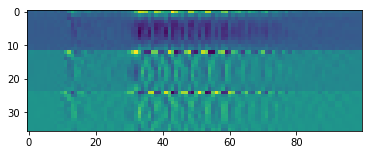

In [42]:
test_img = x_tr[0, 0, :, :]
plt.imshow(test_img)
plt.show()

## 4 Model

I tried roughly 30 different models with focus on newer architectures like residual networks, networks in networks, squeezing and expanding convolutions, but in the end a 5x-Conv-MaxPool worked best. I really wanted to replace the last Dense layers with AveragePooling. They give a little more insight to what's happening in comparison to the "black box"-model that results from dense layers. However it didn't work out as well. I'm guessing this is because spectrograms show a different abstraction of information in comparison to a regular photo showing one object.

In my tests the use of Elu replaced the need for Batch Normalization, which usually improves any model. I didn't include them for performance reasons.

In [43]:
input_num_units = (1, 36, 100)
hidden_num_units = 200
output_num_units = 108

epochs = 10
batch_size = 128

In [44]:
i = Input(shape=input_num_units)
m = Conv2D(16, (3, 3), activation='elu', padding='same')(i)
m = MaxPooling2D()(m)
m = Conv2D(32, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(64, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(128, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(256, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Flatten()(m)
m = Dense(512, activation='elu')(m)
m = Dropout(0.5)(m)
o = Dense(output_num_units, activation='softmax')(m)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 36, 100)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 36, 100)       160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 18, 50)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 18, 50)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 9, 25)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 9, 25)         18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 4, 12)         0         
__________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])
model.fit(x_tr, y_tr, epochs=2, verbose=1, validation_data=(x_va, y_va))

Train on 55208 samples, validate on 1000 samples
Epoch 1/2
12768/55208 [=====>........................] - ETA: 1556s - loss: 4.5013 - categorical_accuracy: 0.0291 - top_k_categorical_accuracy: 0.1248

In [ ]:
#model = load_model('SpellingBee.h5')

In [ ]:
#sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
#model.compile(loss='categorical_crossentropy', optimizer=Nadam(1e-6), metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])
#model.fit(x_tr, y_tr, epochs=15, verbose=1, validation_data=(x_va, y_va))

model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-3), metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])
model.fit(x_tr, y_tr, epochs=2, verbose=1, validation_data=(x_va, y_va))
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-4), metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])
model.fit(x_tr, y_tr, epochs=4, verbose=1, validation_data=(x_va, y_va))
model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])
model.fit(x_tr, y_tr, epochs=4, verbose=1, validation_data=(x_va, y_va))

In [ ]:
sgd = SGD(lr=0.1, decay=0.8, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])

In [ ]:
datagen.fit(x_tr)
model.fit_generator(datagen.flow(x_tr, y_tr, batch_size=16),
                    steps_per_epoch=len(x_tr) / 16, epochs=15, 
                    validation_data=(x_va, y_va))

In [ ]:
model.evaluate(x_te, y_te)

In [ ]:
model.metrics_names

In [ ]:
0.2200000011920929
0.185
model.predict(x_tr)

In [ ]:
model.save('SpellingBee.h5')

In [ ]:
#!pip install -U coremltools
#import coremltools
#coreml_model = coremltools.converters.keras.convert('SpellingBee.h5')
#coreml_model.save('SpellingBee.mlmodel')